<a href="https://colab.research.google.com/github/matyi101/MP2-Code/blob/main/Failure_Detection_SVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from google.colab import data_table

drive.mount('/content/drive/')
data_table.enable_dataframe_formatter()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
from math import log

# DATA INFORMATION:



> The dataset is available publicly for the users from https://www.backblaze.com/b2/hard-drive-test-data.html#how-you-can-use-the-data


> The first row of the each file contains the column names, the remaining rows are the actual data. The columns are as follows:

##### Date – The date of the file in yyyy-mm-dd format.
##### Serial Number – The manufacturer-assigned serial number of the drive.
##### Model – The manufacturer-assigned model number of the drive.
##### Capacity – The drive capacity in bytes.
##### Failure – Contains a “0” if the drive is OK. Contains a “1” if the drive is failed.
##### S.M.A.R.T Attributes - Raw and Normalized.

> In this dataset SMART attributes have two variants namely raw value often corresponds to counts or a physical unit, such as degrees Celsius or seconds and normalized value which ranges from 1 to 253 (1 as worst case and 253 as best case).









# ML PROBLEM FORMULATION:

> It is the Binary class classification problem where we have to predict Hard Drive failure. These are predicted by using attributes that are recorded during normal operations of hard drive. These attributes are known as SMART(Self – Monitoring and Reporting Technology) which is the monitoring system included in computer HDD.

> The motive of this prediction is to reduce the rate of failures as a cost saving measure by the HDD vendors and software running on the host system may notify the user so preventive action can be taken to prevent data loss and failing drive can be replaced and data integrity is maintained.

> The HDD is said to be failed or critical when some of these attributes crosses the threshold values. Depending upon the manufacturers they use different SMART attributes in which the common attributes are like Read Error Rate, Throughput Performance, Spin-Up Time etc.

> References:
###### https://en.wikipedia.org/wiki/S.M.A.R.T
###### https://www.backblaze.com/b2/hard-drive-test-data.html#how-you-can-use-the-data









# PERFORMANCE METRICS:


1.   PRECISION, RECALL SCORES
2.   AUC SCORE AND CONFUSION MATRIX



# 1. Importing Data




In [ ]:
# Using 5 days of data for Train and Val.
# dates = ['02', '03', '04', '05', '06', '07', '08', '09', '10']
dates = ['02', '03', '04', '05']
Data = pd.read_csv("/content/drive/My Drive/hdddata/2021/2021-01-01.csv")
for i in dates:
  Data = Data.append(pd.read_csv("/content/drive/My Drive/hdddata/2021/2021-01-" + i + ".csv"))

In [ ]:
print(Data.info())
print()
print("Shape of the Data: ", Data.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 827509 entries, 0 to 165532
Columns: 149 entries, date to smart_255_raw
dtypes: float64(144), int64(2), object(3)
memory usage: 947.0+ MB
None

Shape of the Data:  (827509, 149)


In [ ]:
Data.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2021-01-01,ZLW0EGC6,ST12000NM001G,12000138625024,0,83.0,213166608.0,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01,Z305B2QN,ST4000DM000,4000787030016,0,114.0,79306032.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01,ZLW0C6NE,ST12000NM001G,12000138625024,0,72.0,17162816.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01,ZJV0XJQ3,ST12000NM0007,12000138625024,0,100.0,1102160.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01,ZLW18MKT,ST14000NM001G,14000519643136,0,75.0,33233248.0,NaN,NaN,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
Data.tail()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
165528,2021-01-05,ZJV2ESXT,ST12000NM0007,12000138625024,0,80.0,97876120.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165529,2021-01-05,ZA13ZBCT,ST8000DM002,8001563222016,0,84.0,227496000.0,NaN,NaN,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165530,2021-01-05,PL1331LAHGD9NH,HGST HMS5C4040BLE640,4000787030016,0,100.0,0.0,134.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165531,2021-01-05,PL2331LAHDS4TJ,HGST HMS5C4040BLE640,4000787030016,0,100.0,0.0,133.0,104.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165532,2021-01-05,X0GEV9EC,WDC WUH721414ALE6L4,14000519643136,0,100.0,0.0,138.0,92.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
Data.reset_index(inplace = True)
Data['date'] = pd.to_datetime(Data['date'])
Data.columns

Index(['index', 'date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized',
       'smart_2_raw',
       ...
       'smart_250_normalized', 'smart_250_raw', 'smart_251_normalized',
       'smart_251_raw', 'smart_252_normalized', 'smart_252_raw',
       'smart_254_normalized', 'smart_254_raw', 'smart_255_normalized',
       'smart_255_raw'],
      dtype='object', length=150)

From the above Dataset it is found that it many features contains NaN values.

# 2. To Find the common features of all the models of HDD.







> Since each vendors provide different SMART attributes, I am finding and keeping the common attributes that each model have defined values.


> Attributes with many NaN are removed.

In [ ]:
# Creating the copy of original data with removing the columns containing all instances as NaN.
Data.drop('index', axis = 1, inplace = True)
Test = Data.dropna(how = 'all', axis = 1)
Initial = Data.columns
Initial

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized',
       'smart_2_raw', 'smart_3_normalized',
       ...
       'smart_250_normalized', 'smart_250_raw', 'smart_251_normalized',
       'smart_251_raw', 'smart_252_normalized', 'smart_252_raw',
       'smart_254_normalized', 'smart_254_raw', 'smart_255_normalized',
       'smart_255_raw'],
      dtype='object', length=149)

In [ ]:
Test.shape # Shape of the data after removing the NaN Features.

(827509, 139)

In [ ]:
# Critical Features for HDD failure as mentioned in Wikipedia and BlackBlaze.
# These features are removed to find other common features of all the models.
Features = ['5', '10', '184', '187', '188', '196', '197', '198']
len(Features)

8

In [ ]:
for i in Features:
  features = ['smart_' + i + '_normalized', 'smart_' + i + '_raw']
  Test.drop(features, axis = 1, inplace = True)

In [ ]:
# Shape of the data after removing the critical features.
Test.shape 

(827509, 123)

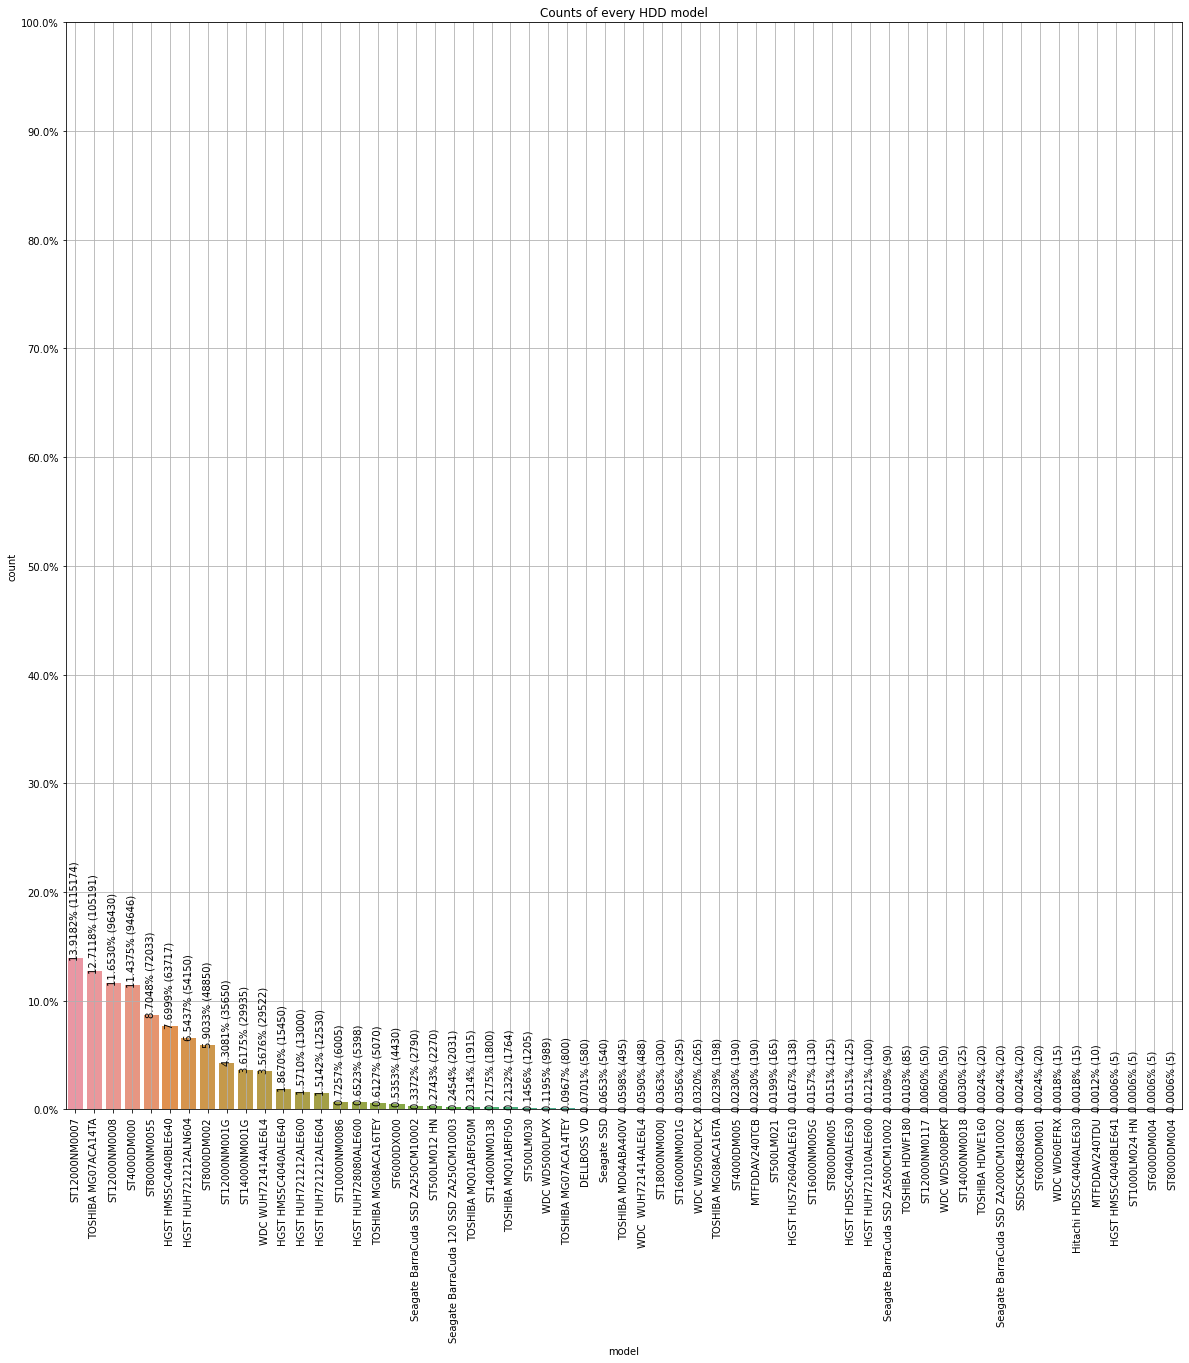

In [ ]:
# Checking the count and percentage of unique models from the data.
total = len(Data)
plt.figure(figsize = (20,20))
ax = sns.countplot(x = "model", data = Test, order = Test.model.value_counts().index)
for p in ax.patches:
        ax.annotate('{:.4f}% ({})'.format(100*p.get_height()/total, p.get_height()), (p.get_x()+0.1, p.get_height()+5), rotation = 'vertical')

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.xticks(rotation=90)
plt.title('Counts of every HDD model')
plt.grid(True)
plt.show()

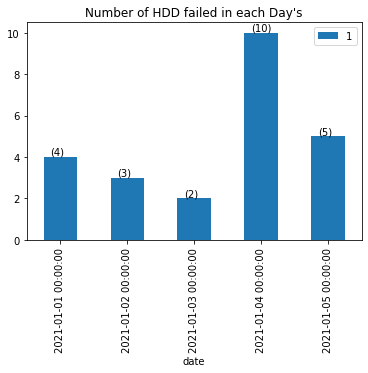

In [ ]:
#This plot tells the number of HDD failed in each days
ax = Test.groupby(['date', 'failure'])['failure'].count().unstack(1)[1].plot.bar()
for p in ax.patches:
        ax.annotate('({})'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.1))
plt.legend()
plt.title("Number of HDD failed in each Day's")
plt.show()

In [ ]:
models = Test.model.value_counts().index
print("Number of Unique Models: ", len(models))
print(models)

Number of Unique Models:  59
Index(['ST12000NM0007', 'TOSHIBA MG07ACA14TA', 'ST12000NM0008', 'ST4000DM000',
       'ST8000NM0055', 'HGST HMS5C4040BLE640', 'HGST HUH721212ALN604',
       'ST8000DM002', 'ST12000NM001G', 'ST14000NM001G', 'WDC WUH721414ALE6L4',
       'HGST HMS5C4040ALE640', 'HGST HUH721212ALE600', 'HGST HUH721212ALE604',
       'ST10000NM0086', 'HGST HUH728080ALE600', 'TOSHIBA MG08ACA16TEY',
       'ST6000DX000', 'Seagate BarraCuda SSD ZA250CM10002', 'ST500LM012 HN',
       'Seagate BarraCuda 120 SSD ZA250CM10003', 'TOSHIBA MQ01ABF050M',
       'ST14000NM0138', 'TOSHIBA MQ01ABF050', 'ST500LM030', 'WDC WD5000LPVX',
       'TOSHIBA MG07ACA14TEY', 'DELLBOSS VD', 'Seagate SSD',
       'TOSHIBA MD04ABA400V', 'WDC  WUH721414ALE6L4', 'ST18000NM000J',
       'ST16000NM001G', 'WDC WD5000LPCX', 'TOSHIBA MG08ACA16TA', 'ST4000DM005',
       'MTFDDAV240TCB', 'ST500LM021', 'HGST HUS726040ALE610', 'ST16000NM005G',
       'ST8000DM005', 'HGST HDS5C4040ALE630', 'HGST HUH721010ALE600',
   

In [ ]:
# Finding the failure rate of every model in 7 days.
for i in models:
  try:
    c = Test[Test.model == i].failure.value_counts()[1] / len(Test[Test.model == i]) * 100
    print(i, 'failure_rate is {:.5f} %'.format(c))
  except KeyError:
    print(i, 'failure_rate is 0 %')

ST12000NM0007 failure_rate is 0.00347 %
TOSHIBA MG07ACA14TA failure_rate is 0.00095 %
ST12000NM0008 failure_rate is 0.00622 %
ST4000DM000 failure_rate is 0.00423 %
ST8000NM0055 failure_rate is 0 %
HGST HMS5C4040BLE640 failure_rate is 0.00157 %
HGST HUH721212ALN604 failure_rate is 0 %
ST8000DM002 failure_rate is 0 %
ST12000NM001G failure_rate is 0.00561 %
ST14000NM001G failure_rate is 0 %
WDC WUH721414ALE6L4 failure_rate is 0 %
HGST HMS5C4040ALE640 failure_rate is 0 %
HGST HUH721212ALE600 failure_rate is 0 %
HGST HUH721212ALE604 failure_rate is 0 %
ST10000NM0086 failure_rate is 0.03331 %
HGST HUH728080ALE600 failure_rate is 0 %
TOSHIBA MG08ACA16TEY failure_rate is 0 %
ST6000DX000 failure_rate is 0 %
Seagate BarraCuda SSD ZA250CM10002 failure_rate is 0 %
ST500LM012 HN failure_rate is 0 %
Seagate BarraCuda 120 SSD ZA250CM10003 failure_rate is 0.04924 %
TOSHIBA MQ01ABF050M failure_rate is 0 %
ST14000NM0138 failure_rate is 0 %
TOSHIBA MQ01ABF050 failure_rate is 0.17007 %
ST500LM030 failure_

From the above it is found that only five models have failed in these 7 days.

In [ ]:
Test.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_242_normalized,smart_242_raw,smart_245_normalized,smart_245_raw,smart_247_normalized,smart_247_raw,smart_248_normalized,smart_248_raw,smart_254_normalized,smart_254_raw
0,2021-01-01,ZLW0EGC6,ST12000NM001G,12000138625024,0,83.0,213166608.0,NaN,NaN,99.0,...,100.0,7.022831e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01,Z305B2QN,ST4000DM000,4000787030016,0,114.0,79306032.0,NaN,NaN,91.0,...,100.0,5.457889e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01,ZLW0C6NE,ST12000NM001G,12000138625024,0,72.0,17162816.0,NaN,NaN,98.0,...,100.0,8.706921e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01,ZJV0XJQ3,ST12000NM0007,12000138625024,0,100.0,1102160.0,NaN,NaN,98.0,...,100.0,1.295292e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01,ZLW18MKT,ST14000NM001G,14000519643136,0,75.0,33233248.0,NaN,NaN,95.0,...,100.0,1.872005e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Finding the features which has NaN percentage greater than 50%
M_features = Test.columns
print(Test.isnull().sum(axis = 0) / len(Test))
index = np.where(Test.isnull().sum(axis = 0) / len(Test) >= 0.5)[0]
len(index) # Count of the found features.

date                    0.000000
serial_number           0.000000
model                   0.000000
capacity_bytes          0.000000
failure                 0.000000
                          ...   
smart_247_raw           0.999988
smart_248_normalized    0.999988
smart_248_raw           0.999988
smart_254_normalized    0.998284
smart_254_raw           0.998284
Length: 123, dtype: float64


90

In [ ]:
M_features[index]

Index(['smart_2_normalized', 'smart_2_raw', 'smart_8_normalized',
       'smart_8_raw', 'smart_11_normalized', 'smart_11_raw',
       'smart_13_normalized', 'smart_13_raw', 'smart_16_normalized',
       'smart_16_raw', 'smart_17_normalized', 'smart_17_raw',
       'smart_18_normalized', 'smart_18_raw', 'smart_22_normalized',
       'smart_22_raw', 'smart_23_normalized', 'smart_23_raw',
       'smart_24_normalized', 'smart_24_raw', 'smart_168_normalized',
       'smart_168_raw', 'smart_170_normalized', 'smart_170_raw',
       'smart_173_normalized', 'smart_173_raw', 'smart_174_normalized',
       'smart_174_raw', 'smart_175_normalized', 'smart_175_raw',
       'smart_177_normalized', 'smart_177_raw', 'smart_179_normalized',
       'smart_179_raw', 'smart_180_normalized', 'smart_180_raw',
       'smart_181_normalized', 'smart_181_raw', 'smart_182_normalized',
       'smart_182_raw', 'smart_183_normalized', 'smart_183_raw',
       'smart_189_normalized', 'smart_189_raw', 'smart_191_normal

##### These are the attributes which have more than 50% of NaN.

# 3. Relevant Features for Dataset

In [ ]:
f = ['date',	'serial_number',	'model',	'capacity_bytes',	'failure']

In [ ]:
Null = np.where(Data.isnull().sum(axis = 0) == len(Data))[0]
len(Initial[Null])

10

In [ ]:
# Dropping the features with all instances as NaN from the original Dataset.
Data.dropna(how = 'all', axis = 1, inplace = True) 
print(Data.shape)
del Test # Removing the Test Dataframe to free the memory.

(827509, 139)


In [ ]:
# Dropping the uncommon features found from above task from the original Dataset.
Data.drop(M_features[index], axis = 1, inplace = True)
Data.shape # Final shape of Data with relevant SMART attributes.

(827509, 49)

In [ ]:
Data.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,...,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
0,2021-01-01,ZLW0EGC6,ST12000NM001G,12000138625024,0,83.0,213166608.0,99.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,4910.0,100.0,4.839342e+10,100.0,7.022831e+10
1,2021-01-01,Z305B2QN,ST4000DM000,4000787030016,0,114.0,79306032.0,91.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,44001.0,100.0,5.940338e+10,100.0,5.457889e+11
2,2021-01-01,ZLW0C6NE,ST12000NM001G,12000138625024,0,72.0,17162816.0,98.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,5414.0,100.0,4.917863e+10,100.0,8.706921e+10
3,2021-01-01,ZJV0XJQ3,ST12000NM0007,12000138625024,0,100.0,1102160.0,98.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,17282.0,100.0,5.260102e+10,100.0,1.295292e+11
4,2021-01-01,ZLW18MKT,ST14000NM001G,14000519643136,0,75.0,33233248.0,95.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,745.0,100.0,1.647225e+10,100.0,1.872005e+10


In [ ]:
Data.describe()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
count,8.275090e+05,827509.000000,826837.000000,8.268370e+05,821146.000000,821146.000000,821146.000000,821146.000000,821366.000000,821366.000000,...,821366.000000,821366.000000,821366.000000,821366.000000,617451.000000,617451.000000,531854.000000,5.318540e+05,531844.000000,5.318440e+05
mean,9.877604e+12,0.000029,92.109367,7.489772e+07,98.571473,1108.194427,99.998563,9.613792,100.555372,39.525386,...,100.420319,0.411193,196.317354,0.523777,99.958756,19539.948509,100.009401,5.612417e+10,100.009401,1.923745e+11
std,3.878876e+12,0.005385,13.814933,8.108625e+07,15.400574,2610.030659,0.105493,113.979821,8.978446,1035.302951,...,7.992256,101.417785,18.833564,37.496426,1.596372,16815.497165,0.969547,1.795249e+10,0.969556,1.765763e+11
min,-1.000000e+00,0.000000,48.000000,0.000000e+00,75.000000,0.000000,75.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,100.000000,0.000000,8.000000,0.000000,100.000000,0.000000e+00,100.000000,1.000000e+00
25%,8.001563e+12,0.000000,81.000000,0.000000e+00,91.000000,0.000000,100.000000,2.000000,100.000000,0.000000,...,100.000000,0.000000,200.000000,0.000000,100.000000,2641.000000,100.000000,4.848800e+10,100.000000,1.001612e+11
50%,1.200014e+13,0.000000,100.000000,4.528490e+07,97.000000,0.000000,100.000000,5.000000,100.000000,0.000000,...,100.000000,0.000000,200.000000,0.000000,100.000000,17421.000000,100.000000,5.912925e+10,100.000000,2.255465e+11
75%,1.200014e+13,0.000000,100.000000,1.441926e+08,100.000000,380.000000,100.000000,10.000000,100.000000,0.000000,...,100.000000,0.000000,200.000000,0.000000,100.000000,33203.000000,100.000000,6.771780e+10,100.000000,2.620806e+11
max,1.800021e+13,1.000000,200.000000,4.515787e+08,253.000000,11111.000000,100.000000,25141.000000,252.000000,65480.000000,...,252.000000,41040.000000,200.000000,7670.000000,100.000000,67845.000000,200.000000,2.202436e+11,200.000000,2.818246e+13


In [ ]:
RE = Data.columns 
RE

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_3_normalized',
       'smart_3_raw', 'smart_4_normalized', 'smart_4_raw',
       'smart_5_normalized', 'smart_5_raw', 'smart_7_normalized',
       'smart_7_raw', 'smart_9_normalized', 'smart_9_raw',
       'smart_10_normalized', 'smart_10_raw', 'smart_12_normalized',
       'smart_12_raw', 'smart_184_normalized', 'smart_184_raw',
       'smart_187_normalized', 'smart_187_raw', 'smart_188_normalized',
       'smart_188_raw', 'smart_190_normalized', 'smart_190_raw',
       'smart_192_normalized', 'smart_192_raw', 'smart_193_normalized',
       'smart_193_raw', 'smart_194_normalized', 'smart_194_raw',
       'smart_196_normalized', 'smart_196_raw', 'smart_197_normalized',
       'smart_197_raw', 'smart_198_normalized', 'smart_198_raw',
       'smart_199_normalized', 'smart_199_raw', 'smart_240_normalized',
       'smart_240_raw', 'smart_241_normalized', 'smart_241_raw',

In [ ]:
# Since the capacity is in "bytes" notation, it is difficult to interpret so it is converted into "GB" notation.
Data['capacity_bytes'] = (Data['capacity_bytes'] // 1e+9)
Data['capacity_bytes'].value_counts() # Finding the counts of each category of HDD based on GB size.

 12000.0    326984
 4000.0     174751
 14000.0    167734
 8001.0     126496
 500.0        8713
 10000.0      6076
 16000.0      5693
 250.0        5361
 6001.0       4490
 480.0         600
 18000.0       300
 240.0         200
-1.0            86
 2000.0         20
 1000.0          5
Name: capacity_bytes, dtype: int64

From the above capacity_bytes unique counts, it is found that there is unmatched size value (-1) which is seems to be odd, so datapoints with that capacity is removed.

In [ ]:
# Removal of odd capacity datapoints.
print(Data.shape)
Data.drop(np.where(Data['capacity_bytes'] == -1)[0], inplace = True)
print(Data.shape)

(827509, 49)
(827423, 49)


In [ ]:
# Filling the NaN values with zero since imputing with anyother values,
# may not be suitable as per the BalckBlaze documentation on SMART attributes.

Data = Data.fillna(0)
Data.isnull().sum(axis = 0)

date                    0
serial_number           0
model                   0
capacity_bytes          0
failure                 0
smart_1_normalized      0
smart_1_raw             0
smart_3_normalized      0
smart_3_raw             0
smart_4_normalized      0
smart_4_raw             0
smart_5_normalized      0
smart_5_raw             0
smart_7_normalized      0
smart_7_raw             0
smart_9_normalized      0
smart_9_raw             0
smart_10_normalized     0
smart_10_raw            0
smart_12_normalized     0
smart_12_raw            0
smart_184_normalized    0
smart_184_raw           0
smart_187_normalized    0
smart_187_raw           0
smart_188_normalized    0
smart_188_raw           0
smart_190_normalized    0
smart_190_raw           0
smart_192_normalized    0
smart_192_raw           0
smart_193_normalized    0
smart_193_raw           0
smart_194_normalized    0
smart_194_raw           0
smart_196_normalized    0
smart_196_raw           0
smart_197_normalized    0
smart_197_ra

# 4. Feature Engineering







> Feature engineering based on correlation of attributes with target variable(Failure).

> Mathematical based feature engineering.

In [ ]:
Test = Data.copy()
Test.shape 

(827423, 49)

In [ ]:
Test.describe()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
count,827423.000000,827423.000000,827423.000000,8.274230e+05,827423.000000,827423.000000,827423.000000,827423.000000,827423.000000,827423.000000,...,827423.000000,827423.000000,827423.000000,827423.000000,827423.000000,827423.000000,827423.000000,8.274230e+05,827423.000000,8.274230e+05
mean,9878.203453,0.000029,92.044133,7.484468e+07,97.823690,1099.787438,99.239953,9.540860,99.819275,39.236047,...,99.685211,0.408183,194.880249,0.519943,74.592601,14581.369804,64.284411,3.607570e+10,64.283202,1.236529e+11
std,3877.916088,0.005386,14.025749,8.108202e+07,17.565005,2601.889063,8.677299,113.549724,12.389478,1031.512115,...,11.691369,101.045904,25.142999,37.358957,43.520472,16831.774762,47.928770,3.050290e+10,47.929130,1.689341e+11
min,240.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,8001.000000,0.000000,81.000000,0.000000e+00,91.000000,0.000000,100.000000,2.000000,100.000000,0.000000,...,100.000000,0.000000,200.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
50%,12000.000000,0.000000,100.000000,4.514909e+07,97.000000,0.000000,100.000000,5.000000,100.000000,0.000000,...,100.000000,0.000000,200.000000,0.000000,100.000000,5816.000000,100.000000,4.683655e+10,100.000000,9.188942e+10
75%,12000.000000,0.000000,100.000000,1.441262e+08,100.000000,380.000000,100.000000,10.000000,100.000000,0.000000,...,100.000000,0.000000,200.000000,0.000000,100.000000,29337.000000,100.000000,6.341446e+10,100.000000,2.468640e+11
max,18000.000000,1.000000,200.000000,4.515787e+08,253.000000,11111.000000,100.000000,25141.000000,252.000000,65480.000000,...,252.000000,41040.000000,200.000000,7670.000000,100.000000,67845.000000,200.000000,2.202436e+11,200.000000,2.818246e+13


##### From the above description it is seen that some attributes have values ranging from 10^7 to 10^13 which seems to be odd. Such attributes are choosen for Feature engineering. 
##### Inspite of Column Standardisation or Normalisation, Sigmoid and Tanh functions are applied on these attributes as a scaling function and it's correlation with target varibale is compared with its original correlation values.

In [ ]:
# Sigmoid and TanH Functions.
# Instead of using original value, it is added with random normal distributed value just like adding bias to the input value.
def Sigmoid(x):
  return 1 / (1 + np.exp(-(x + np.random.normal(scale = 0.5)))) 
def TanH(x):
  return np.tanh(x + np.random.normal(scale = 0.5))

In [ ]:
# Creating new attributes based on above description.

#Test['smart_1_sig'] = Test['smart_1_raw'].apply(Sigmoid)
#Test['smart_7_sig'] = Test['smart_7_raw'].apply(Sigmoid)
#Test['smart_188_sig'] = Test['smart_188_raw'].apply(Sigmoid)
#Test['smart_193_sig'] = Test['smart_193_raw'].apply(Sigmoid)
#Test['smart_240_sig'] = Test['smart_240_raw'].apply(Sigmoid)
#Test['smart_241_sig'] = Test['smart_241_raw'].apply(Sigmoid)
#Test['smart_242_sig'] = Test['smart_242_raw'].apply(Sigmoid)

#Test['smart_1_tan'] = Test['smart_1_raw'].apply(TanH)
#Test['smart_7_tan'] = Test['smart_7_raw'].apply(TanH)
#Test['smart_188_tan'] = Test['smart_188_raw'].apply(TanH)
#Test['smart_193_tan'] = Test['smart_193_raw'].apply(TanH)
#Test['smart_240_tan'] = Test['smart_240_raw'].apply(TanH)
#Test['smart_241_tan'] = Test['smart_241_raw'].apply(TanH)
#Test['smart_242_tan'] = Test['smart_242_raw'].apply(TanH)

cf = ['smart_1_raw', 'smart_7_raw', 'smart_188_raw', 'smart_193_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw']
for i in cf:
   n = re.findall('\d+',i) 
   s = 'smart_' + ''.join(n) + '_sig'
   t = 'smart_' + ''.join(n) + '_tan'
   Test[s] = Test[i].apply(Sigmoid)
   Test[t] = Test[i].apply(TanH)

In [ ]:
Test.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,...,smart_188_sig,smart_188_tan,smart_193_sig,smart_193_tan,smart_240_sig,smart_240_tan,smart_241_sig,smart_241_tan,smart_242_sig,smart_242_tan
0,2021-01-01,ZLW0EGC6,ST12000NM001G,12000.0,0,83.0,213166608.0,99.0,0.0,100.0,...,0.658755,-0.141375,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2021-01-01,Z305B2QN,ST4000DM000,4000.0,0,114.0,79306032.0,91.0,0.0,100.0,...,0.660519,0.292221,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2021-01-01,ZLW0C6NE,ST12000NM001G,12000.0,0,72.0,17162816.0,98.0,0.0,100.0,...,0.706462,-0.045763,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2021-01-01,ZJV0XJQ3,ST12000NM0007,12000.0,0,100.0,1102160.0,98.0,0.0,100.0,...,0.670716,-0.021745,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,2021-01-01,ZLW18MKT,ST14000NM001G,14000.0,0,75.0,33233248.0,95.0,0.0,100.0,...,0.539438,0.370374,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
# Checking the correlation of attributes with target variable.
cf = ['smart_1_raw', 'smart_1_sig', 'smart_1_tan', 'smart_7_raw', 'smart_7_sig', 'smart_7_tan', 'smart_188_raw', 'smart_188_sig', 'smart_188_tan', 'smart_193_raw', 'smart_193_sig', 'smart_193_tan', 'smart_240_raw', 'smart_240_sig', 'smart_240_tan', 'smart_241_raw', 'smart_241_sig', 'smart_241_tan', 'smart_242_raw', 'smart_242_sig', 'smart_242_tan']
j = 1
for i in cf:
  print(i + ' feature' + ' Correlation with target(Failure)' + ' is ' + str(Test[i].corr(Test['failure']))) # This line computes the correlation.
  if(j % 3 == 0):
    print()
  j+=1

smart_1_raw feature Correlation with target(Failure) is 0.0004930565827411704
smart_1_sig feature Correlation with target(Failure) is 0.0013126177063138688
smart_1_tan feature Correlation with target(Failure) is 0.0015404776482304148

smart_7_raw feature Correlation with target(Failure) is -1.8360522051362562e-05
smart_7_sig feature Correlation with target(Failure) is 0.0008324912138650206
smart_7_tan feature Correlation with target(Failure) is 0.0010181727762949618

smart_188_raw feature Correlation with target(Failure) is 0.00044184288658845447
smart_188_sig feature Correlation with target(Failure) is 0.002710240078355296
smart_188_tan feature Correlation with target(Failure) is 0.0016118735461156798

smart_193_raw feature Correlation with target(Failure) is -0.0016981571065426927
smart_193_sig feature Correlation with target(Failure) is -0.004027170957570938
smart_193_tan feature Correlation with target(Failure) is -0.0030840430439657103

smart_240_raw feature Correlation with targe

##### From the above correlation values, attributes obtained from Sigmoid function shows the better correlation than the TanH function. It also show good values when compared with original raw values. 
##### But, smart_241_sig correlation values are still less than it's original raw values, which seems that sigmoidal values dosen't improve the correlation result. Thus, these attributes are not used for feature engineering.

#### Response Encoding the "Model" feature.

> It is a method of creating the True and False probabilities for Categorical Data.

> True Probability = No. of (respec. cat. data with target = 1) / (Total no. of that cat. data).

> False Probability = No. of (respec. cat. data with target = 0) / (Total no. of that cat. data).









In [ ]:
# Function for Claculating the probabilities of categorical data.
def res_fit(cat, Y):
    j = dict(cat.value_counts()) # Storing the counts of each category in Dictionary. 
    true, false = 0, 0
    TRUE, FALSE = {}, {} 
    for key, value in j.items(): # Iterating over each category
        sum, neg, = 0, 0
        for state, y in zip(cat, Y): # Iterating over every data in given Series
            if (key == state and y == 1): 
                sum+= 1              # Calculating count when target of respective category data is 1
            elif (key == state and y == 0):
                neg+= 1              # Calculating count when target of respective category data is 0
        true = sum / value           # Dividing the True count with the respective total category count.
        false = neg / value          # Dividing the False count with the respective total category count.
        TRUE[key] = true
        FALSE[key] = false           # The respective category data with it's True probability and False probability is stored in dictionary.
    return j, TRUE, FALSE

In [ ]:
# Function for transforming the query data points into respective calculated probability values.
def res_transform(cat, TRUE, FALSE):
    t = []
    f = []
    for state in cat: # Iterating over each data point in a given query series.
        for ((key_t, value_t), (key_f, value_f)) in zip(TRUE.items(), FALSE.items()): # Iterating over the calculated True and False probabilities 

            # When the respective category data from query series is matched, it is then appended with it's respective probability values. 
            if state == key_t and state == key_f: 
                t.append(value_t)                 
                f.append(value_f)
                break
        else :           # Incase, when the unknown category data is found, it's True and False probability values are considered as 0.5 and 0.5.
                t.append(1/2)
                f.append(1/2) 

    X_t = np.array(t).reshape(-1, 1)
    X_f = np.array(f).reshape(-1, 1) # Reshaping the above array
    
    return np.concatenate((X_t, X_f), axis = 1) 

In [ ]:
del Test

# 5. Final Dataset





> From the above task, attributes with respective transformation which given better correlation values than it's original raw values are used as a attributes for feature transformation in final dataset.

In [ ]:
print("Original shape of Data : ", Data.shape)
cf = ['smart_1_raw', 'smart_7_raw', 'smart_188_raw', 'smart_193_raw', 'smart_240_raw', 'smart_242_raw']
for i in cf:
   n = re.findall('\d+',i) 
   s = 'smart_' + ''.join(n) + '_sig'
   Data[s] = Data[i].apply(Sigmoid)

print("Final shape of Data : ", Data.shape)

Original shape of Data :  (827423, 49)
Final shape of Data :  (827423, 55)


In [ ]:
Data.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,...,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,smart_1_sig,smart_7_sig,smart_188_sig,smart_193_sig,smart_240_sig,smart_242_sig
0,2021-01-01,ZLW0EGC6,ST12000NM001G,12000.0,0,83.0,213166608.0,99.0,0.0,100.0,...,100.0,4.839342e+10,100.0,7.022831e+10,1.0,1.0,0.340090,1.0,1.0,1.0
1,2021-01-01,Z305B2QN,ST4000DM000,4000.0,0,114.0,79306032.0,91.0,0.0,100.0,...,100.0,5.940338e+10,100.0,5.457889e+11,1.0,1.0,0.331491,1.0,1.0,1.0
2,2021-01-01,ZLW0C6NE,ST12000NM001G,12000.0,0,72.0,17162816.0,98.0,0.0,100.0,...,100.0,4.917863e+10,100.0,8.706921e+10,1.0,1.0,0.469375,1.0,1.0,1.0
3,2021-01-01,ZJV0XJQ3,ST12000NM0007,12000.0,0,100.0,1102160.0,98.0,0.0,100.0,...,100.0,5.260102e+10,100.0,1.295292e+11,1.0,1.0,0.783909,1.0,1.0,1.0
4,2021-01-01,ZLW18MKT,ST14000NM001G,14000.0,0,75.0,33233248.0,95.0,0.0,100.0,...,100.0,1.647225e+10,100.0,1.872005e+10,1.0,1.0,0.512370,1.0,1.0,1.0


In [ ]:
# Splitting the Dataset into Train and Val Dataset based on date
split_date = '2021-01-03'

In [ ]:
Train = Data.loc[Data.date <= split_date]
Val = Data.loc[Data.date > split_date]
print(Train.shape, Val.shape)

(496415, 55) (331008, 55)


In [ ]:
# Response encoding the 'model' feature.
values, TR, FA = res_fit(Train['model'], Train['failure'].values)
print(values)
print()
Train_model = res_transform(Train['model'], TR, FA)
Val_model = res_transform(Val['model'], TR, FA)
print('*'*50)
print(Train_model.shape)
print(Val_model.shape)

{'ST12000NM0007': 69106, 'TOSHIBA MG07ACA14TA': 63099, 'ST12000NM0008': 57859, 'ST4000DM000': 56775, 'ST8000NM0055': 43219, 'HGST HMS5C4040BLE640': 38229, 'HGST HUH721212ALN604': 32490, 'ST8000DM002': 29310, 'ST12000NM001G': 21386, 'ST14000NM001G': 17961, 'WDC WUH721414ALE6L4': 17686, 'HGST HMS5C4040ALE640': 9241, 'HGST HUH721212ALE600': 7800, 'HGST HUH721212ALE604': 7518, 'ST10000NM0086': 3603, 'HGST HUH728080ALE600': 3238, 'TOSHIBA MG08ACA16TEY': 3042, 'ST6000DX000': 2658, 'Seagate BarraCuda SSD ZA250CM10002': 1674, 'ST500LM012 HN': 1362, 'Seagate BarraCuda 120 SSD ZA250CM10003': 1218, 'TOSHIBA MQ01ABF050M': 1149, 'ST14000NM0138': 1080, 'TOSHIBA MQ01ABF050': 1059, 'ST500LM030': 723, 'WDC WD5000LPVX': 593, 'TOSHIBA MG07ACA14TEY': 480, 'DELLBOSS VD': 348, 'Seagate SSD': 324, 'TOSHIBA MD04ABA400V': 297, 'WDC  WUH721414ALE6L4': 293, 'ST18000NM000J': 180, 'ST16000NM001G': 177, 'WDC WD5000LPCX': 159, 'TOSHIBA MG08ACA16TA': 118, 'ST4000DM005': 114, 'MTFDDAV240TCB': 114, 'ST500LM021': 99, 'H

0    496406
1         9
Name: failure, dtype: int64


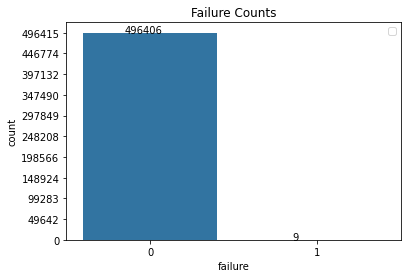

In [ ]:
# Checking the balance of the Train Dataset.
total = len(Train)
print(Train.failure.value_counts())
ax = sns.countplot(x = 'failure', data = Train)
for p in ax.patches:
  ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+5))
ax.yaxis.set_ticks(np.linspace(0, total, 11))
plt.legend()
plt.title("Failure Counts")
plt.show()

0    330993
1        15
Name: failure, dtype: int64


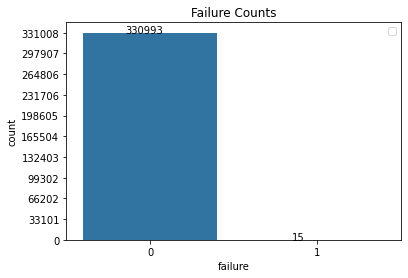

In [ ]:
# Checking the balance of the Val Dataset.
total = len(Val)
print(Val.failure.value_counts())
ax = sns.countplot(x = 'failure', data = Val)
for p in ax.patches:
  ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+5))
ax.yaxis.set_ticks(np.linspace(0, total, 11))
plt.legend()
plt.title("Failure Counts")
plt.show()

From the above, it is found that Dataset is highly imbalanced with class 1 (i.e. HDD is failure) as minority.

In [ ]:
#del Data

In [ ]:
#Train.drop('smart_241_normalized', axis = 1, inplace = True)
#Val.drop('smart_241_normalized', axis = 1, inplace = True)

# 6. Upsampling of Minority Class of Train using SMOTE





> Instead of upsampling the minority class by normal sampling (i.e. creating duplicates of same points) SMOTE technique is used as upsampling technique as it upsamples by interpolation.

In [ ]:
X_Train_orig = Train.drop(f, axis = 1).values
Y_Train_orig = Train.failure.values
X_Val_orig = Val.drop(f, axis = 1).values
Y_Val_orig = Val.failure.values

In [ ]:
X_Train_orig.shape, Y_Train_orig.shape

((496415, 50), (496415,))

In [ ]:
X_Val_orig.shape, Y_Val_orig.shape

((331008, 50), (331008,))

In [ ]:
# Stacking the response encoded array with respective Train and Val dataset.
X_Train_orig = np.hstack((X_Train_orig, Train_model))
X_Val_orig = np.hstack((X_Val_orig, Val_model))
X_Train_orig.shape, X_Val_orig.shape

((496415, 52), (331008, 52))

In [ ]:
del Train_model
del Val_model

In [ ]:
Counter(Y_Train_orig), Counter(Y_Val_orig)

(Counter({0: 496406, 1: 9}), Counter({0: 330993, 1: 15}))

In [ ]:
# SMOTE sampling
# class imblearn.over_sampling.SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=5, m_neighbors='deprecated', out_step='deprecated', kind='deprecated', svm_estimator='deprecated', n_jobs=1, ratio=None)
# k_neighbors (default=5) : number of nearest neighbours to used to construct synthetic samples.
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

under = RandomUnderSampler(sampling_strategy = 0.8)
over_smote = SMOTE(n_jobs = -1, k_neighbors = 1, sampling_strategy = 0.5)
steps = [('o', over_smote), ('u', under)]
pipeline = Pipeline(steps = steps)

In [ ]:
# SMOTE oversampling is applied on Train dataset as per oversampling concepts.
# Since Val dataset is also highly imbalanced, regular oversampling is applied(i.e creating duplicates of minority class)

x_train_sam, y_train_sam = pipeline.fit_resample(X_Train_orig, Y_Train_orig) # Resampling the Training Data by oversampling the minority class using SMOTE 
#and undersampling the majority class.
x_val, y_val = X_Val_orig, Y_Val_orig

In [ ]:
x_train_sam.shape, y_train_sam.shape # Final shape of Train datapoints.

((558456, 52), (558456,))

In [ ]:
x_val.shape, y_val.shape # Final shape of Val datapoints.

((331008, 52), (331008,))

Counter({0: 310253, 1: 248203})


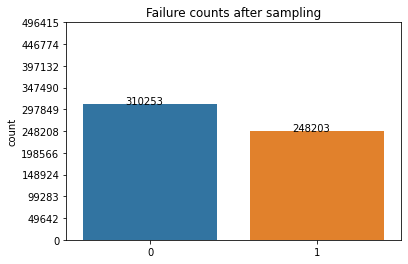

In [ ]:
# Visualization after balancing Train Dataset.
total = len(X_Train_orig)
print(Counter(y_train_sam))
ax = sns.countplot(y_train_sam)
for p in ax.patches:
  ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))
plt.title("Failure counts after sampling")
plt.show()

Counter({0: 330993, 1: 15})


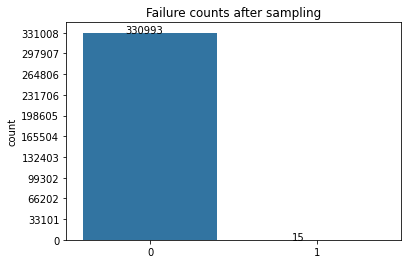

In [ ]:
# Visualization after balancing Val Dataset.
total = len(X_Val_orig)
print(Counter(y_val))
ax = sns.countplot(y_val)
for p in ax.patches:
  ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+5))

ax.yaxis.set_ticks(np.linspace(0, total, 11))
plt.title("Failure counts after sampling")
plt.show()

From the above it is seen that, after oversampling both classes are balanced.

# 7. Standardization:

In [ ]:
from sklearn.preprocessing import Normalizer, StandardScaler
normalizer = Normalizer()
sc = StandardScaler()

In [ ]:
# Standardizing both Train and Val Dataset.
sc.fit(x_train_sam)

X_train_standard = sc.transform(x_train_sam)
X_val_standard = sc.transform(x_val)

In [ ]:
print("Train", np.mean(X_train_standard), np.std(X_train_standard))
print("Val", np.mean(X_val_standard), np.std(X_val_standard))
print(X_train_standard.shape, X_val_standard.shape)

Train 8.138576058221481e-11 1.00000000000069
Val 0.022280775477222937 1.0338737521436392
(558456, 52) (331008, 52)


In [ ]:
X_val_standard[0]

array([-0.69957378,  1.32236923,  0.33758865, -0.48583706,  0.28991213,
       -0.11153156,  0.29029252, -0.33428923,  0.14541655, -0.00203615,
        0.81691176, -0.95441558,  0.264358  , -0.01516239,  0.01869521,
       -0.69564299, -0.65687034, -0.00263455,  1.05747809, -0.13293667,
        0.75547886, -0.03640348,  0.74217297,  0.73490165, -0.01797713,
       -0.22845721,  0.42944151, -0.35027538, -0.62696785, -0.01494602,
       -0.68949209, -0.0081794 ,  0.26599415, -0.24007113,  0.26530395,
       -0.2394277 ,  0.32645605, -0.01024398,  0.56756785, -0.62358732,
        0.67798968,  0.34407019,  0.67799528, -0.41761244,  0.68501445,
        0.72139117,  0.13874333,  0.30765032,  0.73025154,  0.63389327,
       -0.45268544,  0.45268544])

# 8. Test Dataset

In [ ]:
# Creating the Test Dataset to check performance of the model.
# Test data is from 2021-01-06 to 2019-01-07

Dates = ['07']
Test = pd.read_csv("/content/drive/My Drive/hdddata/2021/2021-01-06.csv")
for i in Dates:
  Test = Test.append(pd.read_csv("/content/drive/My Drive/hdddata/2021/2021-01-" + i + ".csv"))

# Test = pd.read_csv("/content/drive/My Drive/hdddata/2021/2021-01-06.csv")
# Test = Test.append(pd.read_csv("/content/drive/My Drive/hdddata/2021/2021-01-07"))

Test.reset_index(inplace = True)
Test.drop('index', axis = 1, inplace = True)
Test.shape

(330211, 149)

In [ ]:
Test.failure.value_counts()

0    330204
1         7
Name: failure, dtype: int64

In [ ]:
# Preprocessing of Test Data.
Test.drop(Initial[Null], axis = 1, inplace = True)
Test.drop(M_features[index], axis = 1, inplace = True)
Test.shape

(330211, 49)

In [ ]:
print(Test.shape)
Test.drop(np.where(Test['capacity_bytes'] == -1)[0], inplace = True)
print(Test.shape)

(330211, 49)
(330155, 49)


In [ ]:
Test.failure.value_counts()

0    330148
1         7
Name: failure, dtype: int64

In [ ]:
Test = Test.fillna(0)

In [ ]:
for i in cf:
   n = re.findall('\d+',i) 
   s = 'smart_' + ''.join(n) + '_sig'
   Test[s] = Test[i].apply(Sigmoid)
Test.shape

(330155, 55)

In [ ]:
Test_model = res_transform(Test['model'], TR, FA)

In [ ]:
X_Test_orig = Test.drop(f, axis = 1).values
Y_Test_orig = Test.failure.values

In [ ]:
X_Test_orig = np.hstack((X_Test_orig, Test_model))
X_Test_orig.shape

(330155, 52)

In [ ]:
x_test, y_test = X_Test_orig, Y_Test_orig

In [ ]:
x_test.shape

(330155, 52)

In [ ]:
(Counter(y_test))

Counter({0: 330148, 1: 7})

In [ ]:
# Standardisation of Test Dataset.
X_test_standard = sc.transform(x_test)
X_test_standard.shape

(330155, 52)

# 9. Modelling

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from random import sample, choice
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, roc_curve, auc, classification_report, f1_score, precision_recall_curve
from scipy.stats import randint as sp_randint, uniform
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import LinearSVC

balance = [{0:1,1:10}, {0:1,1:100}, {0:1,1:1000}, {0:1,1:10000}, {0:10,1:100000}]

In [ ]:
# This function is used to plot Cofusion Matrix, Precision Matrix and Recall Matrix.
def plot_matrices(Y, Y_Pred):
    C = confusion_matrix(Y, Y_Pred) # Confusion Matrix
    
    A =(((C.T)/(C.sum(axis=1))).T) # Calculating Recall Matrix
    
    B =(C/C.sum(axis=0)) # Calculating Precision Matrix
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    print("Sum of rows in recall matrix",A.sum(axis=1))
    
    plt.show()


In [ ]:
# This function prints the metrics of the model.
def Metrics(model, X, Y, threshold):
    y_pred_prob = model.predict_proba(X)[:, 1]
    y_pred = model.predict(X)

    print("The Prescision Score: ", precision_score(Y, predict_with_best_t(y_pred_prob, threshold)))
    print("The Recall Score: ", recall_score(Y, predict_with_best_t(y_pred_prob, threshold)))
    print("The ROC Score: ", roc_auc_score(Y, y_pred_prob))
    print("The F1 Score: ", f1_score(Y, predict_with_best_t(y_pred_prob, threshold)))
    print('*'*100)
    print(classification_report(Y, predict_with_best_t(y_pred_prob, threshold)))
    print('*'*100)
    plot_matrices(Y, predict_with_best_t(y_pred_prob, threshold))

In [ ]:
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

In [ ]:
def find_best_threshold(threshould, fpr, tpr):
    # This function finds the optimal threshold value based on G-Mean metric
    # The Geometric Mean or G-Mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity.
    # Ref: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    t = threshould[np.argmax(np.sqrt(tpr*(1-fpr)))]
    # sqrt(tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of sqrt(tpr*(1-fpr))", max(np.sqrt(tpr*(1-fpr))), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould): # This function predicts class labels based on the optimal threshold value.
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

def BEST(trainscores, testscores, TR, Models): # This function is used to get the best model based on the highest test score.
  ind = np.argmax(testscores)
  test_score = testscores[ind]
  train_score = trainscores[ind]
  threshold = TR[ind]
  best_est = Models[ind]
  return test_score, train_score, threshold, best_est

# 9.2. SVC



> Since Training data is large enough, both libsvm and liblinear solver tends to get hang more time on training the model. Thus, SGD classifier with hinge loss is used as linear SVC.

> As libsvm will take more time on training, kernel SVC are modelled as follows:

1.   Fitting the kernel trick on Training data using sklearn's Nystroem library and then transforming the train, val and test data. This kernel transformation is same as kernel trick done by sklearn svm.
Ref : https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.Nystroem.html#sklearn.kernel_approximation.Nystroem
2.   Then fitting the linear SVC(SGD classifier) over the transformed Data.







In [ ]:
# Hyperparameter tuning of SGD Classifier and Kernel transformation
param = {'alpha' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],
         'penalty' : ['l1', 'l2', 'elasticnet'],
         'l1_ratio' : list(np.sort(np.random.uniform(0, 1, 10))),
         'class_weight' : balance,
         'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
         'degree' : list(np.sort(np.random.randint(1, 7, 10))),
         'gamma' : list(np.sort(np.random.uniform(0, 10, 10))),
         'n_components' : list(30 * np.arange(1, 11))}
svc = SGDClassifier(loss='hinge', n_jobs = -1)
feature_map = Nystroem(random_state=1) # Initialising the kernel transformer.
param

{'alpha': [0.0001,
  0.001,
  0.01,
  0.1,
  1,
  10.0,
  100.0,
  1000.0,
  10000.0,
  100000.0],
 'penalty': ['l1', 'l2', 'elasticnet'],
 'l1_ratio': [0.06346710398165645,
  0.1581392691189918,
  0.3287129279158896,
  0.46947362277793103,
  0.482671849748752,
  0.5288145562348497,
  0.5617889492226862,
  0.7064166101384032,
  0.9089349375073855,
  0.912580034882105],
 'class_weight': [{0: 1, 1: 10},
  {0: 1, 1: 100},
  {0: 1, 1: 1000},
  {0: 1, 1: 10000},
  {0: 10, 1: 100000}],
 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
 'degree': [2, 2, 3, 3, 3, 4, 4, 4, 5, 6],
 'gamma': [1.866035726840779,
  2.835937944607548,
  3.0525080076673206,
  3.8244582473624145,
  4.241920337274623,
  4.845203354053015,
  6.758301236951882,
  7.235434264478771,
  9.240919822607832,
  9.90301741277203],
 'n_components': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300]}

This custom Random SearchCV is built on the original Training dataset with stratifiedkfold split where at each fold the generated training data is sampled and trained with assigned parameter and evaluated on the generated unsampled val data using f1-score metric.

In [ ]:
# Creating custom RandomSearchCV for hyperparameter tuning.
# In this Cross-Validation is done by StratifiedKFold
trainscores = [] # This list is to store the trainscores
testscores  = [] # This list is to store the testscores
Models = [] # This list is to store the models on each iter
TR = []
F = [] # This list is to store the kernel map on each iter

# This loop is to use ten random values for each hyperparameter
for iter in tqdm(range(0, 10)):
  #print(iter)
  Thresholds = []
  trainscores_folds = []
  testscores_folds  = []
  svc = SGDClassifier(loss='hinge', n_jobs = -1)
  feature_map = Nystroem(random_state=1)
  for key, value in param.items(): # Assigns the value for each hyperparameter
    if isinstance(value, list):
      if (key == 'alpha'):
        svc.C = value[iter]
      if (key == 'penalty'):
        svc.penalty = choice(value)
      if (key == 'l1_ratio'):
        svc.l1_ratio = value[iter]
      if (key == 'kernel'):
        feature_map.kernel = choice(value)
      if (key == 'degree'):
        feature_map.degree = value[iter]
      if (key == 'gamma'):
        feature_map.gamma = value[iter]
      if (key == 'n_components'):
        feature_map.n_components = value[iter]
  Models.append(svc)
  F.append(feature_map)
  ss = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1) # Splitting the training data into train and val data using
  # using stratifiedKFold (10-folds) to ensure that each fold consists of both classes.
  # Running the loop for each fold
  for train, test in ss.split(X_Train_orig, Y_Train_orig): # This loop uses original training dataset.
      print()
      X_train = np.zeros(len(train))
      Y_train = np.zeros(len(train))
      X_test = np.zeros(len(test))
      Y_test = np.zeros(len(test))

      # selecting the data points based on the train_indices and test_indices
      X_train = X_Train_orig[train]
      Y_train = Y_Train_orig[train]
      X_test  = X_Train_orig[test]
      Y_test  = Y_Train_orig[test]
      print("B", Counter(Y_train)) # Count of training classes before sampling

      X_train, Y_train = pipeline.fit_resample(X_train, Y_train) # Sampling the training data by the above defined pipeline
      print("A", Counter(Y_train)) # Count of training classes after sampling
      # Standardizing the above train and val data.
      sc = StandardScaler()
      sc.fit(X_train)
      X_train = sc.transform(X_train)
      X_test = sc.transform(X_test)
      # This code snippet applies the kernel transform on Train and Val data
      X_train = feature_map.fit_transform(X_train)
      X_test = feature_map.transform(X_test)
      # This transformed data is used for the model.

      svc.fit(X_train, Y_train)

      Y_predicted_test = svc.predict(X_test)
      print('Test', f1_score(Y_test, Y_predicted_test))
      testscores_folds.append(f1_score(Y_test, Y_predicted_test))

      Y_predicted_train = svc.predict(X_train)
      print('Train', f1_score(Y_train, Y_predicted_train))
      trainscores_folds.append(f1_score(Y_train, Y_predicted_train))

  trainscores.append(np.mean(np.array(trainscores_folds))) # Taking the mean of trainscores obtained from each fold
  testscores.append(np.mean(np.array(testscores_folds))) # Taking the mean of testscores obtained from each fold
  print() 

  0%|          | 0/10 [00:00<?, ?it/s]


B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.9928110951357669

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.9915705274745762

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0024330900243309
Train 0.9894710731355117

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0025380710659898475
Train 0.9903001285631955

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.9900913187988152

B Counter({0: 446765, 1: 9})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.9880661712668083

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})
Test 0.0
Train 0.991449539411343

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})
Test 0.0016694490818030048
Train 0.985696603853511

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})
Test 0.0
Train 0.9917928886501223

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})
Test 

 10%|█         | 1/10 [00:38<05:43, 38.19s/it]

Train 0.9911987806528476


B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.7739950824350729

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.8108103793264934

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.7459389687828833

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.8883016971334593

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.7957161995692478

B Counter({0: 446765, 1: 9})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.7785617857162377

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})
Test 0.0
Train 0.8586763537523407

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})
Test 0.0
Train 0.8300715890464045

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})
Test 0.0
Train 0.9063335827062339

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})
Test 0.0


 20%|██        | 2/10 [01:34<06:29, 48.73s/it]

Train 0.7734435049961569


B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.921607484666427

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.9461898001631898

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.8901651504513913

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.8833056001119322

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.904381766828809

B Counter({0: 446765, 1: 9})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.8876348886197403

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})
Test 0.0
Train 0.9038065200716556

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})
Test 0.0
Train 0.9089352318271743

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})
Test 0.0
Train 0.9513608823694923

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})
Test 0.0


 30%|███       | 3/10 [02:56<07:27, 63.89s/it]

Train 0.9229938662135618


B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.9615550896505556

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.9359620692365029

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.9292080024281648

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.9817581871671525

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.9485261416607644

B Counter({0: 446765, 1: 9})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.9763280265719848

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})
Test 0.0
Train 0.9887908461971934

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})
Test 0.0
Train 0.9456766070464029

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})
Test 0.0
Train 0.9681108809175715

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})
Test 0.0


 40%|████      | 4/10 [04:36<07:49, 78.20s/it]

Train 0.9625389807760627


B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.9529028220807133

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.9251479432282897

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.949692409315402

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.948386489349182

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.9349172519346025

B Counter({0: 446765, 1: 9})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.9324109916367981

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})
Test 0.0
Train 0.932187388713752

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})
Test 0.0
Train 0.9505243995537025

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})
Test 0.0
Train 0.9928517165122868

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})
Test 0.0


 50%|█████     | 5/10 [06:31<07:36, 91.36s/it]

Train 0.952132574709301


B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.765084539348683

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.7901552342383926

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.00029739776951672863
Train 0.7953644656630072

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.00021807872642023773
Train 0.7331639047968589

B Counter({0: 446765, 1: 8})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.7548104295018075

B Counter({0: 446765, 1: 9})
A Counter({0: 279227, 1: 223382})
Test 0.0
Train 0.8098569262525448

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})
Test 0.0
Train 0.7805518439961504

B Counter({0: 446766, 1: 8})
A Counter({0: 279228, 1: 223383})


In [ ]:
print(trainscores)
print(testscores)

In [ ]:
plt.plot(trainscores,label = "Train")
plt.plot(testscores, label = 'Val')
plt.legend()
plt.grid(True)
plt.show()

This plot shows the trainscores and testscores on each iteration

In [ ]:
TR = list(np.zeros(10))
TR

In [ ]:
# Choosing the best model based on highest test score.
test_score, train_score, threshold, est = BEST(trainscores, testscores, TR, Models)
print(test_score, train_score)

In [ ]:
# Getting the best kernel map based on highest test score.
f_map = F[testscores.index(0.006299812654906578)]
f_map

In [ ]:
# Using the best model
svc = est
svc

In [ ]:
# Applying the best kernel transform on Train, Original Val and Original Test Datset.
X_TR = f_map.fit_transform(X_train_standard)
X_VA = f_map.transform(X_val_standard)
X_TE = f_map.transform(X_test_standard)

In [ ]:
# Fitting the calibrated classifier over the best model
sig_clf = CalibratedClassifierCV(svc, method="isotonic")
sig_clf.fit(X_TR, y_train_sam)

In [ ]:
# Threshold Tuning based on the original Val Dataset.
Y_predicted_val = sig_clf.predict_proba(X_VA)[:, 1]

Y_predicted_train = sig_clf.predict_proba(X_TR)[:, 1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_sam, Y_predicted_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, Y_predicted_val)
thresholds = np.linspace(0.0, 1.0, num=len(val_thresholds))
best_t = find_best_threshold(val_thresholds, val_fpr, val_tpr)

In [ ]:
# Getting the metrics based on the optimal threshold value
Metrics(sig_clf, X_TR, y_train_sam, best_t)
print('='*100)
print('='*100)
Metrics(sig_clf, X_VA, y_val, best_t)

In [ ]:
Metrics(sig_clf, X_TE, y_test, best_t)

In [ ]:
# Plotting ROC curve for Train, Val and Test.
Y_predicted_test = sig_clf.predict_proba(X_TE)[:, 1]

test_fpr, test_tpr, te_thresholds = roc_curve(y_test, Y_predicted_test)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(val_fpr, val_tpr, label="val AUC ="+str(auc(val_fpr, val_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

This plot shows the roc_curve of train, val and test dataset.

|  Data| Precision  | Recall | ROC-Score | F1-Score |
|------------|--------|----------------------|----------||
|      Train |  0.7723|           0.9999 |  0.9975 | 0.8714|
|    Val   |  9.629458439257376e-05    | 1.0       |   0.9357 |0.00019|
|    Test  |   9.681666795755558e-05   |    0.8333  |   0.9203 |0.00019|